In [5]:
!pip install transformers tiktoken textract faiss-cpu pandas pypdf langchain matplotlib

  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
     ---------------------------------------- 0.0/635.3 kB ? eta -:--:--
     ----------------------------- ------- 512.0/635.3 kB 10.7 MB/s eta 0:00:01
     ------------------------------------- 635.3/635.3 kB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.5/10.8 MB 31.8 MB/s eta 0:00:01
     ------------ --------------------------- 3.4/10.8 MB 36.3 MB/s eta 0:00:01
     ----------------- ---------------------- 4.7/10.8 MB 33.1 MB/s eta 0:00:01
     ----------------------- ---------------- 6.2/10.8 MB 33.2 MB/s eta 0:00:01
     ------------------------------ --------- 8.1/10.8 MB 34.6 MB/s eta 0:00:01
     ------------------------------- -------- 8.4/10.8 MB 30.0 MB/s eta 0:00:01
     ---------------------------------- ----- 9.4/10.8 MB 31.7 MB/s eta 0:00:01
     --------------------------------------  10.8/10.8 MB 28.5 MB/s eta 0:

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-auth 2.14.1 requires cachetools<6.0,>=2.0.0, which is not installed.
google-auth 2.14.1 requires pyasn1-modules>=0.2.1, which is not installed.
google-auth 2.14.1 requires rsa<5,>=3.1.4; python_version >= "3.6", which is not installed.
google-auth-oauthlib 0.4.6 requires requests-oauthlib>=0.7.0, which is not installed.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [34]:
# os.environ['OPENAI_API_KEY'] = ""

# Loading PDFs

## Split Text

Either by page or by character chunks

In [24]:
mode = 'characters'
# pdf_path = "./pdfs/background_chapter.pdf"
pdf_path = "./pdfs/robust_paper.pdf"

### Split by pages

In [25]:
if mode == 'pages':
    loader = PyPDFLoader(pdf_path)
    pages = loader.load_and_split()
    print(pages[0])

    # SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
    chunks = pages

### Or Split by characters

In [37]:
if mode == 'characters':
    # raise Exception("Not tested this yet, has issues")
    # Step 1: Convert PDF to text
    import textract
    doc = textract.process(pdf_path)

    # Step 2: Save to .txt and reopen (helps prevent issues)
    with open('test.txt', 'w', encoding='utf-8') as f:
        f.write(doc.decode('utf-8'))

    with open('test.txt', 'r', encoding='utf-8') as f:
        text = f.read()

    # Step 3: Create function to count tokens
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

    def count_tokens(text: str) -> int:
        return len(tokenizer.encode(text))

    # Step 4: Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        # chunk_size = 512,
        # chunk_overlap  = 24,
        chunk_size = 100,
        chunk_overlap  = 20,
        length_function = count_tokens,
    )

    chunks = text_splitter.create_documents([text])

In [38]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0]) 

langchain.schema.Document

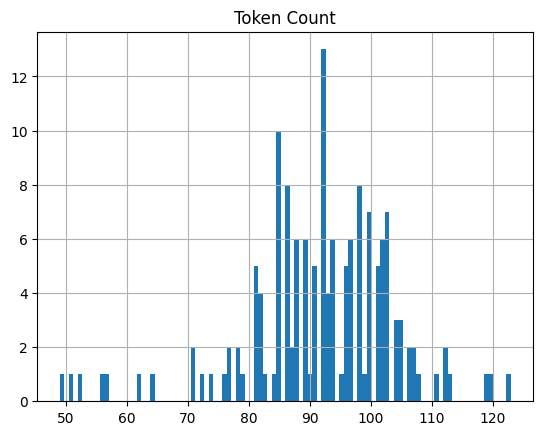

In [39]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=100, )

# Show the plot
plt.show()

# Embed and store

In [40]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# Setup retrieval function

In [44]:
# Check similarity search is working
query = "What's the aim of the paper?"
docs = db.similarity_search(query, )
for doc in docs:
    print(doc)
    print('\n\n')

page_content='e24030417\n\n\n\n1. Introduction\n\nAcademic Editor: Armin Feldhoff\n\nReceived: 24 February 2022\n\nAccepted: 13 March 2022\n\nPublished: 17 March 2022\n\nPublisher’s Note: MDPI stays neutral\n\nwith regard to jurisdictional claims in\n\npublished maps and institutional affiliations.\n\n\n\nCopyright: © 2022 by the authors.\n\nLicensee MDPI, Basel, Switzerland.\n\nThis article is an open access article' metadata={}



page_content='The goal of this paper is to outline the improvements made to the experimental\n\napproach in Ref. [1] that make it more robust at a technical level and applicable to a broader\n\nrange of measurements. From the analytical side, the extraction of ∆S is based on a different\n\nformulation of the Maxwell relation [7],\n\n∆Sµ1 →µ2 =\n\n\n\nZ µ2\n\ndN (µ)\n\nµ1\n\n\n\ndT' metadata={}



page_content='2 of 12\n\n\n\nholds little scientific value and allowed only the determination of entropy change caused\n\nby adding one full electron at a time. At

In [45]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff", verbose=True)

query = "What's the aim of the paper?"
docs = db.similarity_search(query)

response = chain.run(input_documents=docs, question=query)
response



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

e24030417



1. Introduction

Academic Editor: Armin Feldhoff

Received: 24 February 2022

Accepted: 13 March 2022

Published: 17 March 2022

Publisher’s Note: MDPI stays neutral

with regard to jurisdictional claims in

published maps and institutional affiliations.



Copyright: © 2022 by the authors.

Licensee MDPI, Basel, Switzerland.

This article is an open access article

The goal of this paper is to outline the improvements made to the experimental

approach in Ref. [1] that make it more robust at a technical level and applicable to a broader

range of measurements. From the analytical side, the extraction of ∆S is based on a different

formulation of the Maxwell relation [7],

∆Sµ1 →µ2 =



Z µ2

dN (µ)

µ1



d

' The aim of the paper is to outline the improvements made to the experimental approach in Ref. [1] that make it more robust at a technical level and applicable to a broader range of measurements.'

# Create chatbot with chat memory

In [51]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [61]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

chat_history = []

# Create widgets
button = widgets.Button(description="Submit")    # This is the button the user will press when they input something
output = widgets.Output()                        # This is where we'll print the results

# Create a text box for user input
input_box = widgets.Text(
    value='',
    placeholder='Please enter your question...',
)

# Define the button click event
def on_button_clicked(b):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        with output:
            print("Thank you for using the GPTim chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    with output:
        # clear_output()
        display(widgets.HTML(f'<b>User:</b> {query}'))
        display(widgets.HTML(f'<b><font color="green">GPTim:</font></b> {result["answer"]}'))
    
        # # Scroll to the bottom of the output
        # display(HTML("<script>window.scrollTo(0, document.body.scrollHeight);</script>"))

button.on_click(on_button_clicked)

print("Welcome to the GPTim chatbot! Type 'exit' to stop.")
display(input_box, button, output)


Welcome to the GPTim chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question...')

Button(description='Submit', style=ButtonStyle())

Output()

In [ ]:
# db.save_local('test_folder'